## H-K mapping analysis in the Long range Setting

Study the condition for a well defined one-to-one h-k map in a long range ising chain with disorder external field

#### Imports

In [1]:
from src.utils_sparse_diag import adj_generator,ising_coupling,ising_external_field,get_gs,functional_f,compute_magnetization,compute_correlation
from typing import List,Tuple
import matplotlib.pyplot as plt
import quspin
from quspin.basis import spin_basis_1d
import numpy as np
from tqdm import trange

#### Define the universal Hamiltonian

In [8]:
class LongRange():
    def __init__(self,alpha:int,j0:float) -> None:
        self.alpha=alpha
        self.j0=j0

    def long_range(self,i:int,l:int)->Tuple[List[int],List[float]]:
        jdx=[]
        values=[]
        for j in range(-int(l/2),int(l/2)):
            jdx.append((j+i)%l) #append the pbc index
            # the traslational invariance leads to a i-independent relation
            if j==0:
                values.append(0.5*self.j0/((np.abs(j-l))**self.alpha)+0.5*self.j0/((np.abs(j+l))**self.alpha)+0.5*self.j0/((np.abs(j+2*l))**self.alpha)+0.5*self.j0/((np.abs(j-2*l))**self.alpha))
            else:
                values.append(0.5*self.j0/((np.abs(j))**self.alpha)+0.5*self.j0/((np.abs(j-l))**self.alpha)+0.5*self.j0/((np.abs(j+l))**self.alpha)+0.5*self.j0/((np.abs(j+2*l))**self.alpha)+0.5*self.j0/((np.abs(j-2*l))**self.alpha))
        return jdx,values



l=10
ndata=100
alpha=4
j0=1.
hpoints=20
hmax=np.linspace(0.1,5,hpoints)

#### Implement the external field

In [9]:
longrange=LongRange(alpha=alpha,j0=j0)
adj=adj_generator(l=l,f=longrange.long_range)

ham0,f=ising_coupling(adj=adj,l=l,basis=spin_basis_1d(l),direction='zz')

ms:np.ndarray=np.zeros((hpoints,ndata,l,l))
for j,h in enumerate(hmax):
    hs=np.random.uniform(0,h,size=(ndata,l))
    for i in trange(ndata):
        vx=ising_external_field(h=hs[i],l=l,basis=spin_basis_1d(l),direction='x')
        ham=ham0+vx
        e,psi=get_gs(ham=ham,eightype='Std',basis=spin_basis_1d(l),lanczos_dim=100)
        e=e/l    
        x=compute_magnetization(psi=psi,l=l,basis=spin_basis_1d(l),direction='x')
        x=np.asarray(x)
        xx=compute_correlation(psi=psi, l=l, basis=spin_basis_1d(l), direction='xx')
        xx=np.asarray(xx)
        ms[j,i]=xx-x[None,:]*x[:,None]
        
    


100%|██████████| 100/100 [00:10<00:00,  9.81it/s]


## Average of the minimum eigenvalues

In [10]:
l,_=np.linalg.eigh(ms)
print(l.shape)
l=np.abs(l)
l_min=np.min(l,axis=-1)
l_min_av=np.average(l_min,axis=1)

    

(20, 100, 10)


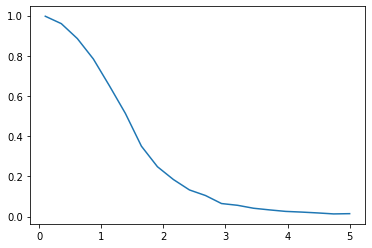

In [11]:
plt.plot(hmax,l_min_av)